## **Notebook to make predictions with reprocessed Yoneda data and SPOT** 


By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime

### SPOT predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with glucose. The data was published in [Yoneda (2016)](https://academic.oup.com/nar/article/44/5/2240/2465306).

#### **Data Labels**

#### Yoneda transcriptomics data: 
* WT 1.0 g/L Glucose, 0.05g/L ammonium sulfate (**WT-LN-G**) (3 trials)

#### Combined with Rhiannon 2018 metabolomics and OD data:
* Metabolomics and OD data for WT Glucose (before **WT-G** but now **WT-LN-G**)
                                                 

### Method: 
<ol>
<li>Predict fluxes with SPOT</li>
<li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
<li>Load file with observed growth rates (Notebook E)</li>
<li>Save growth rate predictions to csv file</li>
</ol>



##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm

from edd_utils import login, export_study, export_metadata

from sklearn.metrics import r2_score

##### **Load data**

In [2]:
# # Study to Download
# study_slug = 'biodesign_yoneda_set3_reprocessed'
# # EDD server
# edd_server = 'public-edd.jbei.org'
# user       = 'schenkch'

In [3]:
# session = login(edd_server=edd_server, user=user)

# df = export_study(session, study_slug, edd_server=edd_server)
# #df.head()

# ##### **Filter transcriptomics data from all EDD data into different dataframes**

In [4]:
# define blank dictionary and fill with transcript measurements from different conditions and carbon sources
transcript_measurements = {}
# add glucose conditions to data set object
transcript_measurements['glucose_cpm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_CPM_melted.csv')
transcript_measurements['glucose_fpkm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_FPKM_melted.csv')
transcript_measurements['glucose_mr'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_MR_melted.csv')
transcript_measurements['glucose_tmm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_TMM_melted.csv')
# add phenol conditions to data set object
# transcript_measurements['phenol_cpm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_CPM_melted.csv')
# transcript_measurements['phenol_fpkm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_FPKM_melted.csv')
# transcript_measurements['phenol_mr'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_MR_melted.csv')
# transcript_measurements['phenol_tmm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_TMM_melted.csv')

##### **Filter transcriptomics data from all EDD data into different dataframes**

In [5]:
# df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
# df_Trans.head()

In [6]:
df_Trans = transcript_measurements['glucose_cpm'] #fpkm

##### **Load Genome Scale Model**

In [7]:
file_name =  '../GSMs/Ropacus_annotated_curated.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import SPOT and utilities Code**

In [8]:
SourceDir = '../src'
sys.path.append(SourceDir)
from ensemblemethods import SPOT
from utils import *

#### **1. SPOT Predictions for Wild type**

In [9]:
spotsol, spotsol_std = spot_pred_for_three_reps(model, df_Trans, 'WT-LN-G-R1', 'WT-LN-G-R2','WT-LN-G-R3', 'glucose')

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

{'EX_glc__D_e': inf,
 'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf}

In [10]:
spotsol.loc['Growth_Glucose',:]

fluxes   -9.452000e-12
Name: Growth_Glucose, dtype: float64

##### **Save solution to data frame**

In [11]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

#### **2. Plot solutions: Comparison of SPOT predictions and 13c measurements**

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [12]:
glucose_fluxes = pd.read_csv('../13C_flux_data/13C_glucose_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
glucose_fluxes.dropna(inplace=True)
print(f'There are {len(glucose_fluxes)} fluxes that can be compared between the MFA and FBA')
glucose_fluxes

There are 31 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00


##### **Add  Glucose EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [13]:
obspred_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, spotsoldf, spotsolstddf, 'glucose', 'SPOT', 'WT')

In [14]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,1.000000e+02,4.701437e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,1.000000e+02,4.701437e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,6.995135e+01,2.906025e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,6.995135e+01,2.906025e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,1.000000e+02,4.701436e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,2.000000e+02,9.402873e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,2.000000e+02,9.402873e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,2.000000e+02,9.403973e+01
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,5.265387e+01,1.059160e+02
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-1.651851e-07,5.824582e-08


##### **Add Glucose SPOT flux values to phenol fluxes dataframe**

In [15]:
obspred_fluxes = add_pred_fluxes_to_13c_df(glucose_fluxes, spotsoldf, spotsolstddf, 'glucose', 'SPOT', 'WT')

In [16]:
obspred_fluxes.to_csv('../13C_flux_data/obspredfluxes_Glucose_SPOT_CPM.csv', index=True, header= True)

In [17]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value
0,Glucose Uptake,reverse_EX_glc__D_e,Gluc.ext + ATP -> G6P,"(50, 460)",100.00,100.00,100.00,1.000000e+02,4.701437e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-1.61,-2.09,1.42,1.000000e+02,4.701437e+01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",0.00,0.00,1.91,6.995135e+01,2.906025e+01
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",0.00,0.00,1.91,6.995135e+01,2.906025e+01
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",0.00,0.00,1.91,1.000000e+02,4.701436e+01
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",86.56,82.61,88.84,2.000000e+02,9.402873e+01
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",86.56,82.61,88.84,2.000000e+02,9.402873e+01
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",78.52,71.65,81.26,2.000000e+02,9.403973e+01
8,EMP Pathway,reverse_PPS or FRUpts2pp or SBTpts or MNLpts o...,2PG <-> PEP,"(-220, -215)",78.52,71.65,81.26,5.265387e+01,1.059160e+02
10,Pentose Phosphate Pathway,G6PDH2r and PGL,G6P <-> 6PG + NADPH,"(50, 380)",100.00,96.96,100.00,-1.651851e-07,5.824582e-08


### **Plot SPOT vs 13C MFA**

##### **Set plot output directory and import plot functions**

In [18]:
output_dir = 'Plots/CPM/'
from plot import *

##### **Plot 13C MFA observations vs. SPOT predictions**

##### Scatter plot: 13CMFA vs. SPOT

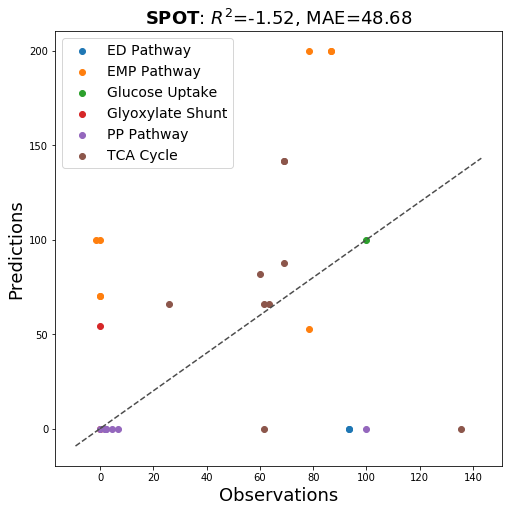

In [19]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='glucose', method='SPOT', strain='WT')

##### **Plot observations vs. predictions with confidence intervals**

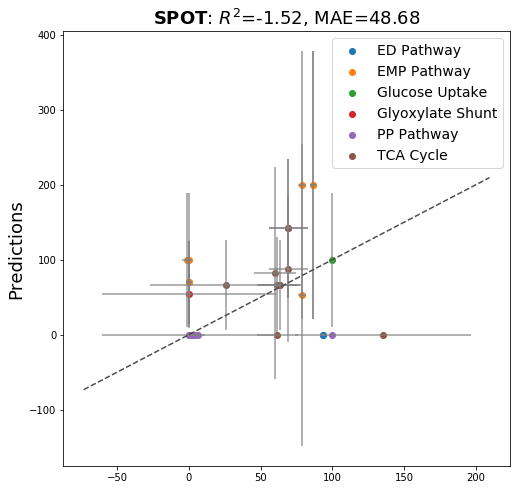

In [20]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='glucose', method='SPOT', strain='WT')

#### **Map glucose SPOT fluxes**

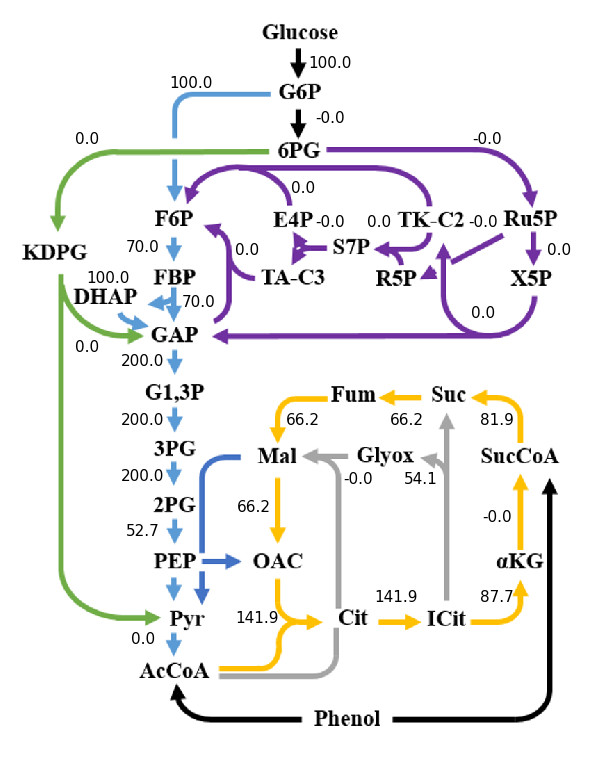

In [21]:
map_flux_results(obspred_fluxes, 'SPOT WT Value')

### **3. Load File with observed growth rates**

##### **Load observed growth rates and plot glucose growth rates**

In [22]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data_new.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785
WT-LN-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675


##### **For comparison of predicted and observed growth rates: scale predicted growth rate by multiplying with (observed substrate uptake / predicted substrate uptake)**

In [23]:
scaledgrowthratespot_wtlng = scale_growth_to_sub(spotsoldf.loc['Growth_Glucose',:].values[0], spotsoldf.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['WT-LN-G', 'substrate consumption rate'])
scaledgrowthratespot_wtlng

-9.451999734008702e-12

##### **Add scaled values to new dataframe**

In [24]:
allgrowthrates=pd.DataFrame(index=['WT-LN-G'], columns=['Growth_Glucose_SPOT' ], dtype=float)#, 'EVOL33-LN-G', 'EVOL40-LN-G'
allgrowthrates.at['WT-LN-G','Growth_Glucose_SPOT'] = scaledgrowthratespot_wtlng

### **4. Save growth rate predictions to csv file**

##### **Save growth rates as csv file**

In [25]:
allgrowthrates.to_csv('../consumption_and_growth_data/allgrowthratesGlucoseSPOT_CPM.csv', index=True, header= True)